In [1]:
import pandas as pd
import spacy
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import csv
import sklearn
import re
import nltk
import pickle
import gensim
import gensim.corpora as corpora
import pyLDAvis
import pyLDAvis.gensim 

from gensim.test.utils import get_tmpfile
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LsiModel, LdaModel

# Download stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords
%matplotlib inline

[nltk_data] Downloading package stopwords to /home/jeff/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
!python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/home/jeff/anaconda3/lib/python3.7/site-packages/en_core_web_sm -->
/home/jeff/anaconda3/lib/python3.7/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [3]:
sm_df = pd.read_json('studymoose.json', orient='records')
phd_df = pd.read_json('phdessay.json', orient='records')
raw_df = pd.concat([sm_df, phd_df], ignore_index=True)
len(raw_df)

85190

In [4]:
# Find text that only newline characters
pd.options.display.max_rows = 999

error_df = raw_df[raw_df['Text'].str.contains('\\n', regex=True)]
error_df = error_df[error_df['Text'].str.len() < 50]
drop_indices = error_df.index.tolist()

In [5]:
# Drop newlines
raw_df.drop(drop_indices, axis=0, inplace=True)
raw_df.reset_index(drop=True, inplace=True)
raw_df.tail()

,Paragraph,Tags,Text,Title,URL
84789,9,"[Change, Affect]",An employer may have to discontinue some insur...,Management Changes Affects Employee Morale,https://phdessay.com/management-changes-affect...
84790,10,"[Change, Affect]","Mossholder, K. W. , Richardson, H. A. , ; Sett...",Management Changes Affects Employee Morale,https://phdessay.com/management-changes-affect...
84791,11,"[Change, Affect]","California Management Review, 34(2), 9-28. Ret...",Management Changes Affects Employee Morale,https://phdessay.com/management-changes-affect...
84792,12,"[Change, Affect]","Academy of Management Journal, 35(5), 1086-109...",Management Changes Affects Employee Morale,https://phdessay.com/management-changes-affect...
84793,13,"[Change, Affect]",How to Cope When Coworkers Lose Their Jobs. Re...,Management Changes Affects Employee Morale,https://phdessay.com/management-changes-affect...


In [6]:
# Split each paragraph into sentences
sentences = raw_df.Text.str.split(r'[.!?] ', expand=True)

In [7]:
# Create a sentence-level data frame by joining the sentences to the raw_df
sent_df = raw_df.drop('Text', axis=1).join(
    sentences.stack().reset_index(drop=True, level=1).rename('Text'))
sent_df.head()

,Paragraph,Tags,Title,URL,Text
0,1,[Climate change],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,Let’s first begin with “what is climate change...
0,1,[Climate change],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,Climate change is caused by several factors [2]:
1,2,[Climate change],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,* Internal forcing mechanism (Natural processe...
2,3,[Climate change],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,"Since the formation of Earth, our planet’s cli..."
3,4,[Climate change],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,The average temperature of the Earth’s surfac...


In [8]:
# Remove lines that are too short
short_df = sent_df[sent_df['Text'].str.len() < 15]
short_indices = short_df.index.tolist()
sent_df.drop(short_indices, axis=0, inplace=True)

In [9]:
sent_df.reset_index(drop=True, inplace=True)
len(sent_df)

243720

In [10]:
from string import punctuation
ref_indices = []
for i in range(len(sent_df)):
    text = sent_df.iloc[i, 4]
    punct = [c for c in text if c in punctuation]
    ratio = len(punct) / len(text)
    if ratio > 0.1:
        ref_indices.append(i)

In [11]:
sent_df.drop(ref_indices, axis=0, inplace=True)
len(sent_df)

241287

In [12]:
# Number each essay
n = 0
essay_dict = {}
for essay in sent_df.URL.unique():
    essay_dict[essay] = n
    n += 1

# Create an Essay column with the number of each essay
sent_df['Essay'] = sent_df['URL'].replace(essay_dict)
sent_df.reset_index(drop= True, inplace=True)
sent_df.head()

,Paragraph,Tags,Title,URL,Text,Essay
0,1,[Climate change],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,Let’s first begin with “what is climate change...,0
1,1,[Climate change],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,Climate change is caused by several factors [2]:,0
2,2,[Climate change],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,* Internal forcing mechanism (Natural processe...,0
3,3,[Climate change],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,"Since the formation of Earth, our planet’s cli...",0
4,4,[Climate change],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,The average temperature of the Earth’s surfac...,0


In [13]:
# Tokenize/Lemmatize text

# Set stopwords for English
stop_words = stopwords.words('english')
stopped = []

for sent in sent_df.Text:
    stopped.append([word for word in sent.split(' ') if word not in stop_words])

# Remove stopwords
len(stopped)

241287

In [14]:
# Load spacy model for tokenizing
try:
    with open ('essays.pickle', 'rb') as fp:
        tokenized_sents = pickle.load(fp)
    print('Pretrained Model loaded!')
  
except:
    nlp = spacy.load('en')
    # Run NLP to get tokens
    tokenized_sents = []
    i = 0
    for sent in stopped:
        i += 1
        if i % 5000 == 0:
            print('Processing {}'.format(i))
        sent = ' '.join(sent)
        doc = nlp(sent)
        # Get lemmas for each word
        tokenized_sents.append([token.lemma_ for token in doc if not token.is_punct])
    
    with open('essays.pickle', 'wb') as fp:
        pickle.dump(tokenized_sents, fp)
    
    print('New model trained!')



Pretrained Model loaded!


In [15]:
# Run LSA on all texts
ts_df = sent_df.copy()
ts_df['Text'] = tokenized_sents
ts_df.head()

,Paragraph,Tags,Title,URL,Text,Essay
0,1,[Climate change],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,"[let, -PRON-, first, begin, what, climate, cha...",0
1,1,[Climate change],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,"[climate, change, cause, several, factor, 2]",0
2,2,[Climate change],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,"[internal, force, mechanism, natural, process,...",0
3,3,[Climate change],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,"[since, formation, Earth, planet, ’s, climate,...",0
4,4,[Climate change],Climate Change (Class Project) Essay,https://studymoose.com/climate-change-class-pr...,"[ , the, average, temperature, Earth, ’s, surf...",0


In [16]:
essays = ts_df.groupby('Essay')['Text'].apply(lambda x: list(x))

In [17]:
paragraphs = ts_df.groupby(['Essay', 'Paragraph'])['Text'].apply(lambda x: list(x))
print(paragraphs[1])

Paragraph
1    [[Pakistan, fifth, large, population, country,...
2    [[in, Pakistan, issue, global, climate, change...
4    [[United, Nations, Pakistan, try, play, major,...
5    [[-PRON-, believe, Kyoto, Protocol, help, Paki...
6    [[this, immensely, help, Pakistan, achieve, su...
Name: Text, dtype: object


In [18]:
# Run LDA on all texts
# Create Dictionary
id2word = corpora.Dictionary(essays[0])

for i in range(1, len(essays)):
    try:
        id2word.add_documents(essays[i])
    except:
        print('Error: {}'.format(i))
    if i % 500 == 0:
        print('Processed line {}'.format(i))
        
# Create Corpus
texts = []
for essay in essays:
    texts.append([e for para in essay for e in para])

# Term Document Frequency
corpus = []
for i in range(len(texts)):
    try:
        corpus.append(id2word.doc2bow(texts[i]))
    except:
        print('Error: {}'.format(i))

# View
print(corpus[:1])

Processed line 500
Processed line 1000
Processed line 1500
Processed line 2000
Processed line 2500
Processed line 3000
Processed line 3500
Processed line 4000
Processed line 4500
Processed line 5000
Processed line 5500
Processed line 6000
Processed line 6500
Processed line 7000
[[(0, 6), (1, 1), (2, 1), (3, 7), (4, 9), (5, 3), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 3), (13, 1), (14, 1), (15, 3), (16, 1), (17, 3), (18, 1), (19, 2), (20, 2), (21, 1), (22, 2), (23, 1), (24, 1), (25, 2), (26, 2), (27, 2), (28, 8), (29, 1), (30, 1), (31, 2), (32, 1), (33, 2), (34, 1), (35, 2), (36, 1), (37, 1), (38, 1), (39, 1), (40, 2), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 2), (48, 1), (49, 1), (50, 2), (51, 3), (52, 2), (53, 3), (54, 1), (55, 1), (56, 10), (57, 1), (58, 5), (59, 1), (60, 1), (61, 2), (62, 7), (63, 2), (64, 3), (65, 1), (66, 2), (67, 2), (68, 1), (69, 2), (70, 1), (71, 1), (72, 2), (73, 1), (74, 2), (75, 1), (76, 1), (77, 1), (78, 1), (79, 4), (80, 4),

In [19]:
with open('corpus.pickle', 'wb') as fp:
        pickle.dump(corpus, fp)

In [25]:
try:
    lda16_model = LdaModel.load('checkpoints/lda16.model')
    
except:
    # Build LDA model
    lda16_model = LdaModel(corpus=corpus,
                         id2word=id2word,
                         num_topics=16, 
                         random_state=42,
                         update_every=1,
                         chunksize=100,
                         passes=10,
                         alpha='auto',
                         per_word_topics=True)
    # Save model
    lda16_model.save('checkpoints/lda16.model')

/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-

In [26]:
# Write model info to dataframe
model = 'LDA'
n = 16
topics = lda16_model.print_topics()
perplexity = lda16_model.log_perplexity(corpus)

coherence_model_lda = CoherenceModel(model=lda16_model,
                                     texts=texts, 
                                     dictionary=id2word, 
                                     coherence='c_v')

coherence = coherence_model_lda.get_coherence()

model_info = pd.DataFrame.from_dict({'Model Type': model, 
                                     'Num_Topics': n, 
                                     'Topics': topics, 
                                     'Perplexity': perplexity, 
                                     'Coherence': coherence})

In [22]:
try:
    lsa16_model = LsiModel.load('checkpoints/lsa16.model')
    
except:
    # Build LSA Model
    lsa16_model = LsiModel(corpus=corpus,
                        id2word=id2word,
                        num_topics=16, 
                        chunksize=100)

    lsa16_model.save('checkpoints/lsa16.model')

/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [23]:
# Add model info to dataframe
model = 'LSA'
n = 16
topics = lsa16_model.print_topics()
perplexity = 'N/A'

coherence_model_lsa = CoherenceModel(model=lsa16_model,
                                     texts=texts, 
                                     dictionary=id2word, 
                                     coherence='c_v')

coherence = coherence_model_lsa.get_coherence()

model_info = pd.concat([model_info,
                       pd.DataFrame.from_dict({'Model Type': model, 
                                     'Num_Topics': n, 
                                     'Topics': topics, 
                                     'Perplexity': perplexity, 
                                     'Coherence': coherence})], 
                      ignore_index=True)

In [24]:
model_info

,Model Type,Num_Topics,Topics,Perplexity,Coherence
0,LDA,16,"(0, 0.019*""the"" + 0.015*""change"" + 0.014*""clim...",-11.2163,0.481355
1,LDA,16,"(1, 0.033*""Program"" + 0.002*""violator"" + 0.000...",-11.2163,0.481355
2,LDA,16,"(2, 0.071*""health"" + 0.036*""drug"" + 0.036*""pat...",-11.2163,0.481355
3,LDA,16,"(3, 0.178*""water"" + 0.041*""energy"" + 0.039*""te...",-11.2163,0.481355
4,LDA,16,"(4, 0.022*""right"" + 0.021*""human"" + 0.018*""the...",-11.2163,0.481355
5,LDA,16,"(5, 0.078*""child"" + 0.062*""school"" + 0.051*""st...",-11.2163,0.481355
6,LDA,16,"(6, 0.050*""social"" + 0.031*""technology"" + 0.03...",-11.2163,0.481355
7,LDA,16,"(7, 0.000*""Markus"" + 0.000*""Pashtuns"" + 0.000*...",-11.2163,0.481355
8,LDA,16,"(8, 0.025*""the"" + 0.020*""change"" + 0.010*""use""...",-11.2163,0.481355
9,LDA,16,"(9, 0.026*""woman"" + 0.021*""culture"" + 0.021*""s...",-11.2163,0.481355


In [25]:
try:
    lda12_model = LdaModel.load('checkpoints/lda12.model')
    
except:
    # Build LDA model
    lda12_model = LdaModel(corpus=corpus,
                         id2word=id2word,
                         num_topics=12, 
                         random_state=42,
                         update_every=1,
                         chunksize=100,
                         passes=10,
                         alpha='auto',
                         per_word_topics=True)
    # Save model
    lda12_model.save('checkpoints/lda12.model')

/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-

In [26]:
# Write model info to dataframe
model = 'LDA'
n = 12
topics = lda12_model.print_topics()
perplexity = lda12_model.log_perplexity(corpus)

coherence_model_lda = CoherenceModel(model=lda12_model,
                                     texts=texts, 
                                     dictionary=id2word, 
                                     coherence='c_v')

coherence = coherence_model_lda.get_coherence()

model_info = pd.concat([model_info,
                       pd.DataFrame.from_dict({'Model Type': model, 
                                     'Num_Topics': n, 
                                     'Topics': topics, 
                                     'Perplexity': perplexity, 
                                     'Coherence': coherence})], 
                      ignore_index=True)

In [27]:
try:
    lda20_model = LdaModel.load('checkpoints/lda20.model')
    
except:
    # Build LDA model
    lda20_model = LdaModel(corpus=corpus,
                         id2word=id2word,
                         num_topics=20, 
                         random_state=42,
                         update_every=1,
                         chunksize=100,
                         passes=10,
                         alpha='auto',
                         per_word_topics=True)
    # Save model
    lda20_model.save('checkpoints/lda20.model')

/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-

In [28]:
# Write model info to dataframe
model = 'LDA'
n = 20
topics = lda20_model.print_topics()
perplexity = lda20_model.log_perplexity(corpus)

coherence_model_lda = CoherenceModel(model=lda20_model,
                                     texts=texts, 
                                     dictionary=id2word, 
                                     coherence='c_v')

coherence = coherence_model_lda.get_coherence()

model_info = pd.concat([model_info,
                       pd.DataFrame.from_dict({'Model Type': model, 
                                     'Num_Topics': n, 
                                     'Topics': topics, 
                                     'Perplexity': perplexity, 
                                     'Coherence': coherence})], 
                      ignore_index=True)

In [29]:
try:
    lda24_model = LdaModel.load('checkpoints/lda24.model')
    
except:
    # Build LDA model
    lda24_model = LdaModel(corpus=corpus,
                         id2word=id2word,
                         num_topics=24, 
                         random_state=42,
                         update_every=1,
                         chunksize=100,
                         passes=10,
                         alpha='auto',
                         per_word_topics=True)
    # Save model
    lda24_model.save('checkpoints/lda24.model')

/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-

In [30]:
# Write model info to dataframe
model = 'LDA'
n = 24
topics = lda24_model.print_topics()
perplexity = lda24_model.log_perplexity(corpus)

coherence_model_lda = CoherenceModel(model=lda24_model,
                                     texts=texts, 
                                     dictionary=id2word, 
                                     coherence='c_v')

coherence = coherence_model_lda.get_coherence()

model_info = pd.concat([model_info,
                       pd.DataFrame.from_dict({'Model Type': model, 
                                     'Num_Topics': n, 
                                     'Topics': topics, 
                                     'Perplexity': perplexity, 
                                     'Coherence': coherence})], 
                      ignore_index=True)

In [31]:
try:
    lsa12_model = LsiModel.load('checkpoints/lsa12.model')
    
except:
    # Build LSA Model
    lsa12_model = LsiModel(corpus=corpus,
                        id2word=id2word,
                        num_topics=12, 
                        chunksize=100)

    lsa12_model.save('checkpoints/lsa12.model')

/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-

In [32]:
# Add model info to dataframe
model = 'LSA'
n = 12
topics = lsa12_model.print_topics()
perplexity = 'N/A'

coherence_model_lsa = CoherenceModel(model=lsa12_model,
                                     texts=texts, 
                                     dictionary=id2word, 
                                     coherence='c_v')

coherence = coherence_model_lsa.get_coherence()

model_info = pd.concat([model_info,
                       pd.DataFrame.from_dict({'Model Type': model, 
                                     'Num_Topics': n, 
                                     'Topics': topics, 
                                     'Perplexity': perplexity, 
                                     'Coherence': coherence})], 
                      ignore_index=True)

In [33]:
try:
    lsa20_model = LsiModel.load('checkpoints/lsa20.model')
    
except:
    # Build LSA Model
    lsa20_model = LsiModel(corpus=corpus,
                        id2word=id2word,
                        num_topics=20, 
                        chunksize=100)

    lsa20_model.save('checkpoints/lsa20.model')

/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-

In [34]:
# Add model info to dataframe
model = 'LSA'
n = 20
topics = lsa20_model.print_topics()
perplexity = 'N/A'

coherence_model_lsa = CoherenceModel(model=lsa20_model,
                                     texts=texts, 
                                     dictionary=id2word, 
                                     coherence='c_v')

coherence = coherence_model_lsa.get_coherence()

model_info = pd.concat([model_info,
                       pd.DataFrame.from_dict({'Model Type': model, 
                                     'Num_Topics': n, 
                                     'Topics': topics, 
                                     'Perplexity': perplexity, 
                                     'Coherence': coherence})], 
                      ignore_index=True)

In [35]:
try:
    lsa24_model = LsiModel.load('checkpoints/lsa24.model')
    
except:
    # Build LSA Model
    lsa24_model = LsiModel(corpus=corpus,
                        id2word=id2word,
                        num_topics=24, 
                        chunksize=100)

    lsa24_model.save('checkpoints/lsa24.model')

/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-

In [36]:
# Add model info to dataframe
model = 'LSA'
n = 24
topics = lsa24_model.print_topics()
perplexity = 'N/A'

coherence_model_lsa = CoherenceModel(model=lsa24_model,
                                     texts=texts, 
                                     dictionary=id2word, 
                                     coherence='c_v')

coherence = coherence_model_lsa.get_coherence()

model_info = pd.concat([model_info,
                       pd.DataFrame.from_dict({'Model Type': model, 
                                     'Num_Topics': n, 
                                     'Topics': topics, 
                                     'Perplexity': perplexity, 
                                     'Coherence': coherence})], 
                      ignore_index=True)

In [38]:
model_info.groupby('Coherence').count()

,Model Type,Num_Topics,Topics,Perplexity
Coherence,,,,
0.315673,20,20,20,20
0.326912,20,20,20,20
0.348967,16,16,16,16
0.350129,12,12,12,12
0.445811,12,12,12,12
0.481355,16,16,16,16
0.484358,20,20,20,20
0.522117,20,20,20,20


In [41]:
try:
    lda22_model = LdaModel.load('checkpoints/lda22.model')
    
except:
    # Build LDA model
    lda22_model = LdaModel(corpus=corpus,
                         id2word=id2word,
                         num_topics=22, 
                         random_state=42,
                         update_every=1,
                         chunksize=100,
                         passes=10,
                         alpha='auto',
                         per_word_topics=True)
    # Save model
    lda22_model.save('checkpoints/lda22.model')

/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-

In [42]:
# Write model info to dataframe
model = 'LDA'
n = 22
topics = lda22_model.print_topics()
perplexity = lda22_model.log_perplexity(corpus)

coherence_model_lda = CoherenceModel(model=lda22_model,
                                     texts=texts, 
                                     dictionary=id2word, 
                                     coherence='c_v')

coherence = coherence_model_lda.get_coherence()

model_info = pd.concat([model_info,
                       pd.DataFrame.from_dict({'Model Type': model, 
                                     'Num_Topics': n, 
                                     'Topics': topics, 
                                     'Perplexity': perplexity, 
                                     'Coherence': coherence})], 
                      ignore_index=True)
print('LDA Coherence: {}'.format(coherence))

LDA Coherence: 0.4791654969432159


In [43]:
try:
    lda26_model = LdaModel.load('checkpoints/lda26.model')
    
except:
    # Build LDA model
    lda26_model = LdaModel(corpus=corpus,
                         id2word=id2word,
                         num_topics=26, 
                         random_state=42,
                         update_every=1,
                         chunksize=100,
                         passes=10,
                         alpha='auto',
                         per_word_topics=True)
    # Save model
    lda26_model.save('checkpoints/lda26.model')

/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-

In [44]:
# Write model info to dataframe
model = 'LDA'
n = 26
topics = lda26_model.print_topics()
perplexity = lda26_model.log_perplexity(corpus)

coherence_model_lda = CoherenceModel(model=lda26_model,
                                     texts=texts, 
                                     dictionary=id2word, 
                                     coherence='c_v')

coherence = coherence_model_lda.get_coherence()

model_info = pd.concat([model_info,
                       pd.DataFrame.from_dict({'Model Type': model, 
                                     'Num_Topics': n, 
                                     'Topics': topics, 
                                     'Perplexity': perplexity, 
                                     'Coherence': coherence})], 
                      ignore_index=True)
print('LDA Coherence: {}'.format(coherence))

LDA Coherence: 0.48725684971553435


In [45]:
try:
    lda28_model = LdaModel.load('checkpoints/lda28.model')
    
except:
    # Build LDA model
    lda28_model = LdaModel(corpus=corpus,
                         id2word=id2word,
                         num_topics=28, 
                         random_state=42,
                         update_every=1,
                         chunksize=100,
                         passes=10,
                         alpha='auto',
                         per_word_topics=True)
    # Save model
    lda28_model.save('checkpoints/lda28.model')

/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/home/jeff/anaconda3/lib/python3.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-

In [46]:
# Write model info to dataframe
model = 'LDA'
n = 28
topics = lda28_model.print_topics()
perplexity = lda28_model.log_perplexity(corpus)

coherence_model_lda = CoherenceModel(model=lda28_model,
                                     texts=texts, 
                                     dictionary=id2word, 
                                     coherence='c_v')

coherence = coherence_model_lda.get_coherence()

model_info = pd.concat([model_info,
                       pd.DataFrame.from_dict({'Model Type': model, 
                                     'Num_Topics': n, 
                                     'Topics': topics, 
                                     'Perplexity': perplexity, 
                                     'Coherence': coherence})], 
                      ignore_index=True)
print('LDA Coherence: {}'.format(coherence))

LDA Coherence: 0.45675750158391665


/home/jeff/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


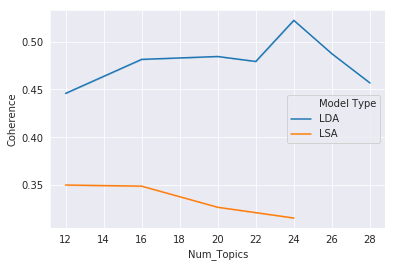

In [48]:
# Compare topic models
sns.set_style('darkgrid')

sns.lineplot(x='Num_Topics', 
             y='Coherence', 
             hue='Model Type', 
             data=model_info)
plt.show()

In [49]:
model_info.groupby('Coherence').count()

,Model Type,Num_Topics,Topics,Perplexity
Coherence,,,,
0.315673,20,20,20,20
0.326912,20,20,20,20
0.348967,16,16,16,16
0.350129,12,12,12,12
0.445811,12,12,12,12
0.456758,20,20,20,20
0.479165,20,20,20,20
0.481355,16,16,16,16
0.484358,20,20,20,20


In [51]:
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 2.7MB/s eta 0:00:01     |██▉                             | 143kB 2.7MB/s eta 0:00:01
     |████████████████████████████████| 286kB 24.1MB/s eta 0:00:01
     |████████████████████████████████| 829kB 28.2MB/s eta 0:00:01
  Stored in directory: /home/jeff/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Stored in directory: /home/jeff/.cache/pip/wheels/0c/61/d2/d6b7317325828fbb39ee6ad559dbe4664d0896da4721bf379e
Successfully built pyLDAvis future


In [52]:
import pyLDAvis
import pyLDAvis.gensim

# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda24_model, corpus, id2word)
vis

/home/jeff/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
18    -0.293826  0.122953       1        1  28.184908
19    -0.313902  0.099095       2        1  21.912756
17    -0.290153  0.138931       3        1  11.910237
4     -0.213672  0.145336       4        1   6.949921
0     -0.266153 -0.043025       5        1   6.466366
22    -0.207917 -0.075747       6        1   4.464653
15    -0.194822  0.097008       7        1   3.537107
13    -0.061003  0.043413       8        1   2.872123
6     -0.060634 -0.050963       9        1   2.527923
5     -0.049684 -0.042732      10        1   1.869734
10    -0.095459 -0.026390      11        1   1.855991
21    -0.094057 -0.279992      12        1   1.531879
23    -0.037286 -0.318554      13        1   1.335190
2      0.045039  0.027716      14        1   1.334238
16     0.094993 -0.028922      15        1   0.991694
3      0.016976 -0.161142      16        1   0.884714
11     0.152501  0.033356      17        1   0.637609
7      0.251245  0.035992      18        1   0.305978
1      0.262432  0.041518      19        1   0.190464
8      0.248302  0.031862      20        1   0.138751
9      0.263506  0.047103      21        1   0.081932
14     0.280244  0.053456      22        1   0.014192
20     0.281666  0.054863      23        1   0.000823
12     0.281666  0.054863      24        1   0.000816, topic_info=      Category          Freq  \
term                           
0      Default  59896.000000   
490    Default   8718.000000   
3320   Default   7803.000000   
348    Default  15193.000000   
1702   Default   6125.000000   
293    Default   9308.000000   
859    Default   8960.000000   
48     Default  10550.000000   
79     Default   7694.000000   
1466   Default   7802.000000   
817    Default   5402.000000   
1569   Default   6683.000000   
58     Default  27598.000000   
1827   Default   5203.000000   
3      Default  34509.000000   
563    Default   5071.000000   
3357   Default   4288.000000   
247    Default   8012.000000   
4      Default   5040.000000   
3469   Default   4683.000000   
56     Default  46397.000000   
229    Default   7904.000000   
614    Default   7470.000000   
656    Default   3647.000000   
758    Default   6347.000000   
179    Default   7579.000000   
626    Default   9694.000000   
17     Default   8175.000000   
3808   Default   2518.000000   
340    Default   4801.000000   
545     Topic1   7477.732910   
882     Topic1   4547.487305   
1777    Topic1   3842.085938   
1789    Topic1   2585.395264   
514     Topic1   2174.199951   
1810    Topic1   1991.422729   
2146    Topic1   1943.135742   
1168    Topic1   1612.373535   
639     Topic1   1588.617676   
9       Topic1   1202.081543   
265     Topic1   1116.606323   
599     Topic1    834.267944   
969     Topic1    792.940674   
970     Topic1    773.669373   
1547    Topic1    758.798645   
3292    Topic1    736.660339   
2879    Topic1    686.960083   
3235    Topic1    671.238403   
3467    Topic1    651.776123   
2048    Topic1    648.114563   
184     Topic1    641.002563   
2288    Topic1    596.510742   
267     Topic1    582.355652   
2162    Topic1    574.324524   
2076    Topic1    532.350220   
1263    Topic1    525.801086   
2886    Topic1    505.734283   
2628    Topic1    496.753082   
4117    Topic1    447.594360   
439     Topic1    443.829529   
155     Topic1   9634.506836   
0       Topic1  57955.949219   
1235    Topic1   6541.858398   
151     Topic1   6231.343262   
326     Topic1   2808.482178   
649     Topic1   4555.498047   
33      Topic1   1609.434204   
95      Topic1   1663.312012   
805     Topic1   5951.873047   
240     Topic1   6207.565430   
3070    Topic1   1888.133789   
223     Topic1   5286.244141   
1034    Topic1   2568.278564   
1082    Topic1   2175.877197   
262     Topic1   6254.822266   
642     Topic1   3903.180176   
928     Topic1   1555.985596   
236     Topic1  10398.083

In [57]:
# Code attributed to https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
def format_topics_sentences(ldamodel=lda24_model, corpus=corpus, texts=texts):
    # Init output
    essay_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                essay_topics_df = essay_topics_df.append(pd.Series([int(topic_num), 
                                                                    round(prop_topic,4), 
                                                                    topic_keywords]), 
                                                         ignore_index=True)
            else:
                break
    essay_topics_df.columns = ['Dominant_Topic', 'Percent_Contrib', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    essay_topics_df = pd.concat([essay_topics_df, contents], axis=1)
    return(essay_topics_df)


df_topic_essay_keywords = format_topics_sentences(ldamodel=lda24_model, corpus=corpus, texts=texts)

# Format
df_dominant_topic = df_topic_essay_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Percent_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Percent_Contrib,Keywords,Text
0,0,18.0,0.3044,"-PRON-, ’s, people, the, one, would, make, not...","[let, -PRON-, first, begin, what, climate, cha..."
1,1,19.0,0.4620,"change, the, use, this, process, in, also, sys...","[Pakistan, fifth, large, population, country, ..."
2,2,19.0,0.2498,"change, the, use, this, process, in, also, sys...","[historical, climate, change, profound, effect..."
3,3,0.0,0.2342,"country, global, market, product, economic, wo...","[one, great, challenge, earth, face, Global, W..."
4,4,19.0,0.3252,"change, the, use, this, process, in, also, sys...","[discuss, challenge, global, warming, present,..."
5,5,19.0,0.3214,"change, the, use, this, process, in, also, sys...","[Green, Cabs, environmentally, friendly, taxi,..."
6,6,19.0,0.3488,"change, the, use, this, process, in, also, sys...","[for, nation, adapt, climate, change, become, ..."
7,7,19.0,0.2327,"change, the, use, this, process, in, also, sys...","[Assume, 100, year, continuous, temperature, r..."
8,8,19.0,0.2000,"change, the, use, this, process, in, also, sys...","[the, Earth, fever, fever, rise, -PRON-, wrong..."
9,9,18.0,0.3113,"-PRON-, ’s, people, the, one, would, make, not...","[to, put, simple, term, climate, change, refer..."


In [60]:
# Code attributed to https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
# Group top 5 essays under each topic
essay_topics_sorteddf = pd.DataFrame()

essay_topics_groupeddf = df_topic_essay_keywords.groupby('Dominant_Topic')

for i, grp in essay_topics_groupeddf:
    essay_topics_sorteddf = pd.concat([essay_topics_sorteddf, 
                                             grp.sort_values(['Percent_Contrib'], ascending=[0]).head(5)], 
                                            axis=0)

# Reset Index    
essay_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
essay_topics_sorteddf.columns = ['Topic_Num', "Topic_Percent_Contrib", "Keywords", "Text"]

# Show
essay_topics_sorteddf

,Topic_Num,Topic_Percent_Contrib,Keywords,Text
0,0.0,0.6602,"country, global, market, product, economic, wo...","[East, Asia, South, Asia, similar, promote, ec..."
1,0.0,0.6240,"country, global, market, product, economic, wo...","[textile, industry, significant, segment, dist..."
2,0.0,0.6225,"country, global, market, product, economic, wo...","[the, industrialized, nation, know, Great, Bri..."
3,0.0,0.6142,"country, global, market, product, economic, wo...","[globalization, interaction, different, econom..."
4,0.0,0.5891,"country, global, market, product, economic, wo...","[globalization, mainly, concentrate, trade, co..."
5,2.0,0.3002,"religion, human, God, religious, belief, life,...","[Ian, Markham, book, state, view, religion, va..."
6,2.0,0.2982,"religion, human, God, religious, belief, life,...","[assess, view, religious, belief, practice, ch..."
7,2.0,0.2782,"religion, human, God, religious, belief, life,...","[Most, argument, concern, abortion, issue, hin..."
8,2.0,0.2520,"religion, human, God, religious, belief, life,...","[the, United, Nations, define, human, right, r..."
9,3.0,0.2211,"company, organization, employee, business, cus...","[health, care, benefit, optional, employer, cr..."


In [65]:
# Number of Documents for Each Topic
topic_counts = df_topic_essay_keywords.groupby('Topic_Keywords')['Dominant_Topic'].count()
topic_counts

Topic_Keywords
-PRON-, ’s, people, the, one, would, make, not, life, time                                      3463
change, the, use, this, process, in, also, system, ’s, management                               1911
child, school, student, bully, education, family, parent, young, teacher, age                     22
company, organization, employee, business, customer, work, job, worker, workplace, employer        1
country, global, market, product, economic, world, change, industry, environmental, increase     382
crime, police, death, punishment, penalty, criminal, officer, law, capital, justice              165
energy, food, gas, warming, temperature, use, cause, emission, waste, human                       23
government, right, state, the, law,   , United, country, States, people                          359
health, patient, care, disease, marijuana, medical, treatment, mental, stress, suicide            62
increase, year,   , rate, high, low, million, population, percent, cost     

In [84]:
tags = ts_df.groupby('Essay')['Tags'].apply(lambda x: np.unique(x)[0])

'Climate change'

In [85]:
# Get topics for tags
tokenized_tags =[]

nlp = spacy.load('en')
i = 0
for tag in tags:
    i += 1
    if i % 5000 == 0:
        print('Processing {}'.format(i))
    tag = ' '.join(tag)
    doc = nlp(tag)
    # Get lemmas for each word
    tokenized_tags.append([token.lemma_ for token in doc if not token.is_punct])


Processing 5000


,Dominant_Topic,Percent_Contrib,Topic_Keywords,0
0,18.0,0.3044,"-PRON-, ’s, people, the, one, would, make, not...","[climate, change]"
1,19.0,0.4620,"change, the, use, this, process, in, also, sys...","[climate, change]"
2,19.0,0.2498,"change, the, use, this, process, in, also, sys...","[climate, change]"
3,0.0,0.2342,"country, global, market, product, economic, wo...","[War, Global, warming]"
4,19.0,0.3252,"change, the, use, this, process, in, also, sys...","[War, Global, warming]"
5,19.0,0.3214,"change, the, use, this, process, in, also, sys...","[Environment, Climate, change]"
6,19.0,0.3489,"change, the, use, this, process, in, also, sys...","[Government, Climate, change]"
7,19.0,0.2326,"change, the, use, this, process, in, also, sys...","[Earth, Climate, change]"
8,19.0,0.2000,"change, the, use, this, process, in, also, sys...","[art, earth]"
9,18.0,0.3113,"-PRON-, ’s, people, the, one, would, make, not...","[Earth, Climate, change]"


In [86]:
tags_topics_df = format_topics_sentences(ldamodel=lda24_model, corpus=corpus, texts=tokenized_tags)
tags_topics_df.columns = ['Tag_Topic', 'Tag_Percent_Contrib', 'Tag_Keywords', 'Tags']
tags_topics_df.head()

,Tag_Topic,Tag_Percent_Contrib,Tag_Keywords,Tags
0,18.0,0.3044,"-PRON-, ’s, people, the, one, would, make, not...","[climate, change]"
1,19.0,0.4620,"change, the, use, this, process, in, also, sys...","[climate, change]"
2,19.0,0.2498,"change, the, use, this, process, in, also, sys...","[climate, change]"
3,0.0,0.2342,"country, global, market, product, economic, wo...","[War, Global, warming]"
4,19.0,0.3253,"change, the, use, this, process, in, also, sys...","[War, Global, warming]"


In [87]:
essaytags_topicsdf = df_dominant_topic.join(tags_topics_df)
essaytags_topicsdf.head()

,Document_No,Dominant_Topic,Topic_Percent_Contrib,Keywords,Text,Tag_Topic,Tag_Percent_Contrib,Tag_Keywords,Tags
0,0,18.0,0.3044,"-PRON-, ’s, people, the, one, would, make, not...","[let, -PRON-, first, begin, what, climate, cha...",18.0,0.3044,"-PRON-, ’s, people, the, one, would, make, not...","[climate, change]"
1,1,19.0,0.4620,"change, the, use, this, process, in, also, sys...","[Pakistan, fifth, large, population, country, ...",19.0,0.4620,"change, the, use, this, process, in, also, sys...","[climate, change]"
2,2,19.0,0.2498,"change, the, use, this, process, in, also, sys...","[historical, climate, change, profound, effect...",19.0,0.2498,"change, the, use, this, process, in, also, sys...","[climate, change]"
3,3,0.0,0.2342,"country, global, market, product, economic, wo...","[one, great, challenge, earth, face, Global, W...",0.0,0.2342,"country, global, market, product, economic, wo...","[War, Global, warming]"
4,4,19.0,0.3252,"change, the, use, this, process, in, also, sys...","[discuss, challenge, global, warming, present,...",19.0,0.3253,"change, the, use, this, process, in, also, sys...","[War, Global, warming]"
